In [1]:
from sklearn.ensemble import RandomForestRegressor
from math import nan
import math
import numpy as np
import pandas as pd
import csv
import pdb
import os
import matplotlib.pyplot as plt
import timeit
import feda # feda.py must be in same directory

In [2]:
def load_data(directory, target_var):
    full_data = []
    if directory[-1] != '/':
        directory = directory + '/'
    for root,dir,files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                filepath = directory + file
                print('Loading: ', file)
                csv_data = np.genfromtxt(filepath, delimiter=',')
                full_data.append(csv_data)
    try:
        features = np.vstack(full_data)
        ground_truth = features[:,target_var]
        features = np.delete(features, target_var, axis=1)
    except:
        print("Loading Error: Data not found")
    
    return features, ground_truth, full_data
    

In [3]:
def load_data_cv(directory, target_var):
    print("Loading data")
    full_data = []
    file_names = []
    ground_truth = []
    features = []
    if directory[-1] != '/':
        directory = directory + '/'
    for root,dir,files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                filepath = directory + file
                print('Loading: ', file)
                csv_data = np.genfromtxt(filepath, delimiter=',')
                full_data.append(csv_data)
                file_names.append(file)
    for file in range(0,len(full_data)):
        ground_truth.append(full_data[file][:,target_var])
        features.append(np.delete(full_data[file], target_var, axis=1))
        
    return features, ground_truth, full_data, file_names

In [4]:
truth_index = 2
start = timeit.default_timer()
source_features, _, source_data = load_data('/mnt/d/git/heat_chamber_code/jupyter/pid train/', truth_index)
trans_source_features, source_truth=feda.source_transform(source_data, truth_index)

Loading:  1.50AlTemps151540PID.csv
Loading:  1.50AlTemps151545PID.csv
Loading:  1.50AlTemps151550PID.csv
Loading:  1.50AlTemps151555PID.csv
Loading:  1.50AlTemps151560PID.csv
Loading:  1.75AlTemps151540PID.csv
Loading:  1.75AlTemps151545PID.csv
Loading:  1.75AlTemps151550PID.csv
Loading:  1.75AlTemps151555PID.csv
Loading:  1.75AlTemps151560PID.csv
Loading:  2.00AlTemps151540PID.csv
Loading:  2.00AlTemps151545PID.csv
Loading:  2.00AlTemps151550PID.csv
Loading:  2.00AlTemps151555PID.csv
Loading:  2.00AlTemps151560PID.csv
Loading:  2.25AlTemps151540PID.csv
Loading:  2.25AlTemps151545PID.csv
Loading:  2.25AlTemps151550PID.csv
Loading:  2.25AlTemps151555PID.csv
Loading:  2.25AlTemps151560PID.csv


In [5]:
truth_index = 2
start = timeit.default_timer()
cv_features, cv_truth, cv_full_data, cv_file_names = load_data_cv('/mnt/d/git/heat_chamber_code/jupyter/real_cross_validation/', truth_index)

Loading data
Loading:  max40_kalman.csv
Loading:  max60run1_kalman.csv
Loading:  max60run2_kalman.csv


# Transfer Learning Using Frustratingly Easy Domain Adaptation (FEDA)

In [6]:
trans_cv_features = []
trans_cv_truth = []
for i in range(len(cv_full_data)):
    target_features, target_truth=feda.target_transform(cv_full_data[i], truth_index)
    trans_cv_features.append(target_features)
    trans_cv_truth.append(target_truth)

In [7]:
train_set_features = []
train_set_truth = []
train_features = []
train_truth = []
num_runs = len(trans_cv_features)
# Build leave one hold out training sets
for test_run in range(0,num_runs):
    for train_run in range(0, num_runs):
        if test_run != train_run:
            train_features.append(trans_cv_features[train_run])
            train_truth.append(trans_cv_truth[train_run])
            
    train_features.append(trans_source_features)
    train_truth.append(source_truth)
    train_set_truth.append(np.hstack(train_truth))
    train_set_features.append(np.vstack(train_features))
    train_truth = []
    train_features = []

In [8]:
forest = RandomForestRegressor(random_state=42)
trans_score= []
trans_prediction_array = []
trans_truth_array = []
trans_error_array = []
for run in range(0,num_runs):
    forest.fit(train_set_features[run], train_set_truth[run])
    trans_score.append(forest.score(trans_cv_features[run], trans_cv_truth[run]))
    run_predictions = []
    run_truth = []
    temp_err = []
    index = 0
    for sample in range(0, len(trans_cv_features[run])):
        prediction = forest.predict([trans_cv_features[run][sample]])
        run_predictions.append(prediction)
        temp_err.append(100*abs((trans_cv_truth[run][sample] - prediction)/trans_cv_truth[run][sample]))
        index = index + 1
    run_predictions = np.vstack(run_predictions)
    trans_error_array.append(np.vstack(temp_err))
    trans_prediction_array.append(run_predictions)
    trans_truth_array.append(trans_cv_truth[run])
    

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [9]:
average_score = str(np.average(trans_score))
print('Transfer Learning Cross validation score: ' + average_score)

Transfer Learning Cross validation score: 0.5757377494579372


# Augmenting Real Data with Simulated Data without using FEDA

In [10]:
train_set_features = []
train_set_truth = []
train_features = []
train_truth = []
num_runs = len(cv_features)
# Build leave one hold out training sets
for test_run in range(0,num_runs):
    for train_run in range(0, num_runs):
        if test_run != train_run:
            train_features.append(cv_features[train_run])
            train_truth.append(cv_truth[train_run])
            
    train_features.append(source_features)
    train_truth.append(source_truth)
    train_set_truth.append(np.hstack(train_truth))
    train_set_features.append(np.vstack(train_features))
    train_truth = []
    train_features = []

In [11]:
forest = RandomForestRegressor(random_state=42)
score = []
prediction_array = []
truth_array = []
error_array = []
for run in range(0,num_runs):
    forest.fit(train_set_features[run], train_set_truth[run])
    score.append(forest.score(cv_features[run], cv_truth[run]))
    run_predictions = []
    run_truth = []
    temp_err = []
    index = 0
    for sample in range(0, len(cv_features[run])):
        prediction = forest.predict([cv_features[run][sample]])
        run_predictions.append(prediction)
        temp_err.append(100*abs((cv_truth[run][sample] - prediction)/cv_truth[run][sample]))
        index = index + 1
    run_predictions = np.vstack(run_predictions)
    error_array.append(np.vstack(temp_err))
    prediction_array.append(run_predictions)
    truth_array.append(cv_truth[run])
    

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [12]:
average_score = str(np.average(score))
print('Cross validation score: ' + average_score)

Cross validation score: 0.5354828874928769


Transfer Learning Score: -0.1592296847201324
Standard Scores: -0.24707840620187027


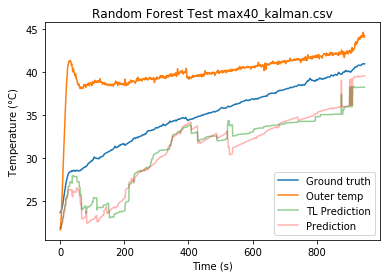

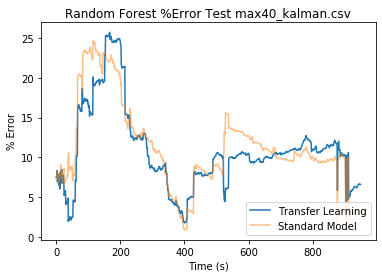

Transfer Learning Score: 0.9673271468208505
Standard Scores: 0.9399412041261158


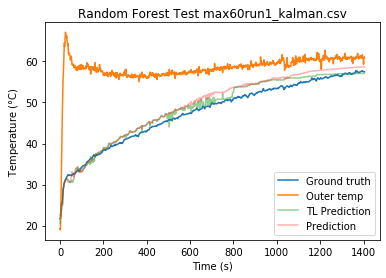

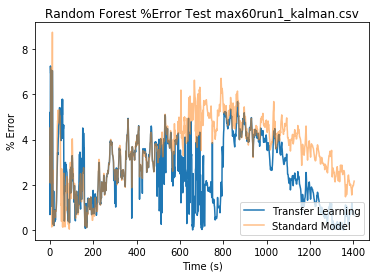

Transfer Learning Score: 0.9191157862730935
Standard Scores: 0.9135858645543851


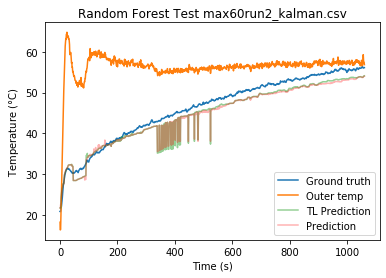

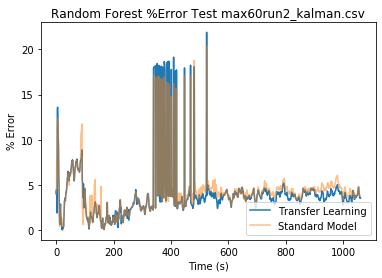

Time:  333.12869579999995


In [22]:
for i in range(0,num_runs):
    trans_score_str = str(trans_score[i])
    score_str = str(score[i])
    print('Transfer Learning Score: ' + trans_score_str)
    print('Standard Scores: ' + score_str)
    plt.figure
    plt.plot(range(len(truth_array[i])), trans_truth_array[i], label="Ground truth")
    plt.plot(range(len(truth_array[i])), trans_cv_features[i][:,4], label="Outer temp")
    plt.plot(range(len(truth_array[i])), trans_prediction_array[i], label="TL Prediction", alpha=0.5)
    plt.plot(range(len(truth_array[i])), prediction_array[i], 'r', label="Prediction", alpha=0.3)
    plt.legend(loc="lower right")
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature ($\degree$C)')
    plt.title('Random Forest Test ' + cv_file_names[i])
    plt.show()
    plt.figure
    plt.plot(range(len(trans_error_array[i])), trans_error_array[i], label="Transfer Learning")
    plt.plot(range(len(error_array[i])), error_array[i], label="Standard Model", alpha=0.5, )
    plt.legend(loc="lower right")
    plt.xlabel('Time (s)')
    plt.ylabel('% Error')
    plt.title('Random Forest %Error Test ' + cv_file_names[i])
    plt.show()

stop = timeit.default_timer()
print('Time: ', stop - start)  